In [15]:
import os
import numpy as np
import pandas as pd
from tabulate import tabulate
from matplotlib import pyplot as plt
import seaborn as sn
import random
from skimage.io import imread, imsave
from skimage.feature import greycomatrix, greycoprops
import cv2
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
dir_imagenes_5="images_5/"
dir_labels_5="annotations_5/trimaps_5/"
dir_imagenes="images/"
dir_labels="annotations/trimaps/"
%matplotlib inline

## Ejemplos de imágenes

staffordshire_bull_terrier_15.jpg
Bombay_137.jpg
Abyssinian_128.jpg
Russian_Blue_112.jpg
Bengal_77.jpg
american_bulldog_69.jpg


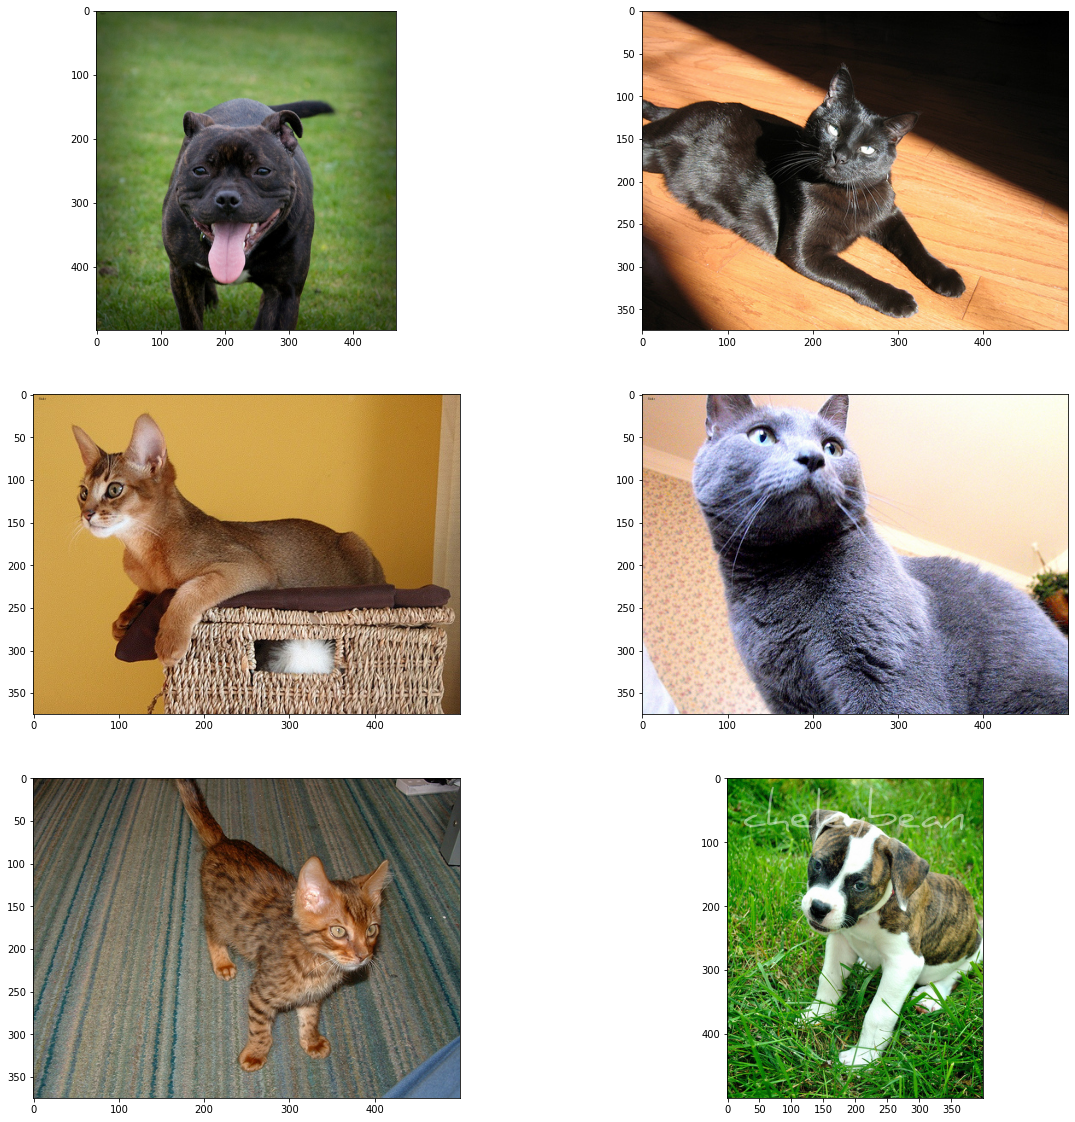

In [3]:
archivos= os.listdir(dir_imagenes)


fig, axs = plt.subplots(3,2,figsize=(20,20))
k=0
for j in range(3):
    for i in range(2):
        print(archivos[k])

        J1 = cv2.imread(dir_imagenes+archivos[k])
        J1=cv2.cvtColor(J1, cv2.COLOR_BGR2RGB)

        axs[j,i].imshow(J1)
        k=k+1

  


staffordshire_bull_terrier_15.jpg
Bombay_137.jpg
Abyssinian_128.jpg
Russian_Blue_112.jpg
Bengal_77.jpg
american_bulldog_69.jpg


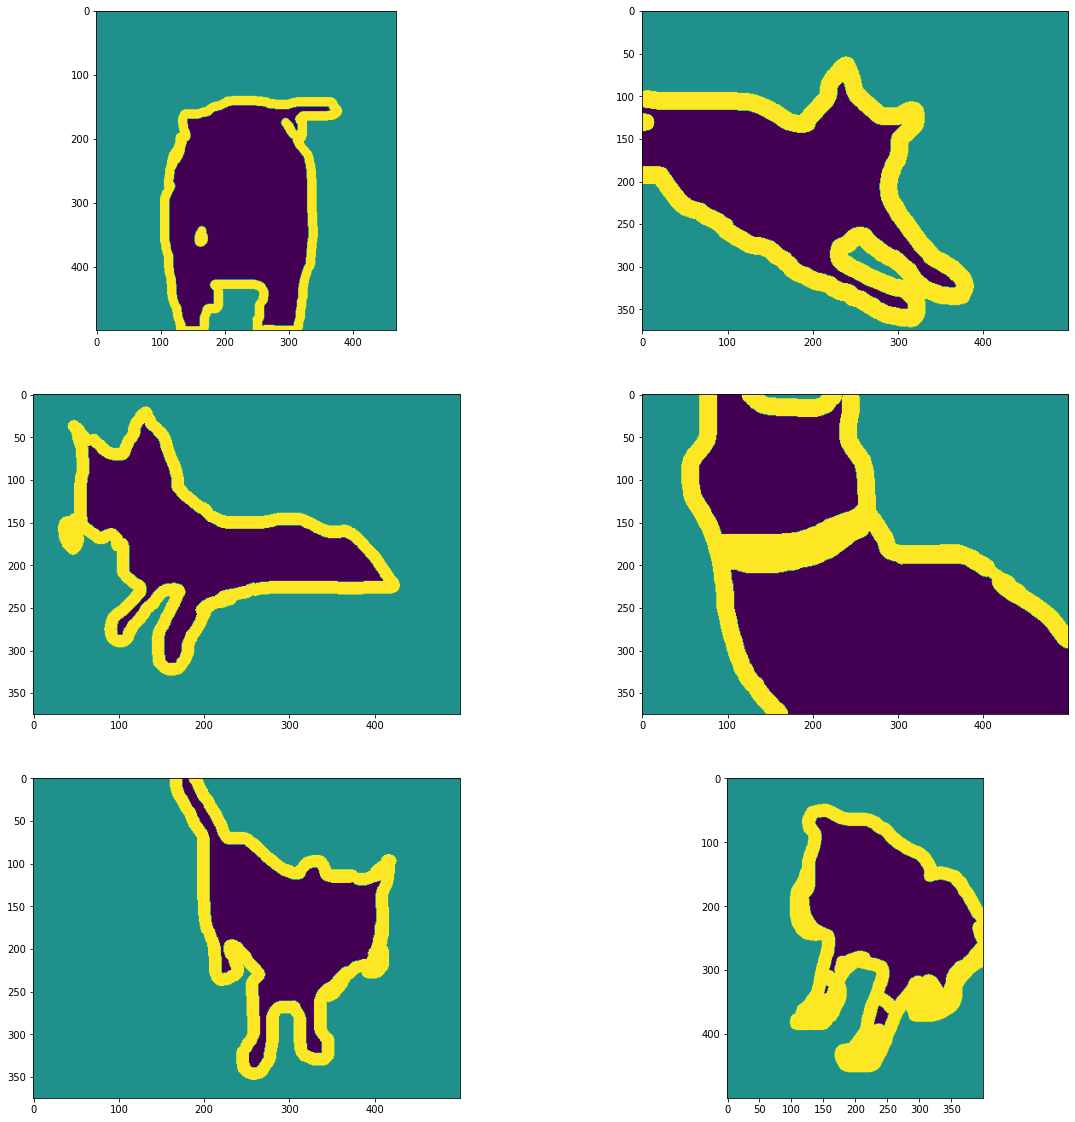

In [4]:
from skimage.io import imread, imsave
#archivos= os.listdir(dir_labels)


fig, axs = plt.subplots(3,2,figsize=(20,20))
k=0
for j in range(3):
    for i in range(2):
        print(archivos[k])
        J1=imread(dir_labels+archivos[k].replace('.jpg','.png'))
       # J1=cv2.cvtColor(J1, cv2.COLOR_BGR2RGB)
        axs[j,i].imshow(J1)
        k=k+1


## Segmentación

<Figure size 432x288 with 0 Axes>

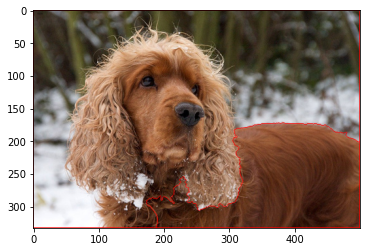

<Figure size 432x288 with 0 Axes>

In [59]:
J1 = cv2.imread(dir_imagenes+archivos[9])
J1=cv2.cvtColor(J1, cv2.COLOR_BGR2RGB)

gray = cv2.cvtColor(J1,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0


markers = cv2.watershed(J1,markers)
J1[markers == -1] = [255,0,0]
plt.imshow(J1)
plt.figure()


<Figure size 432x288 with 0 Axes>

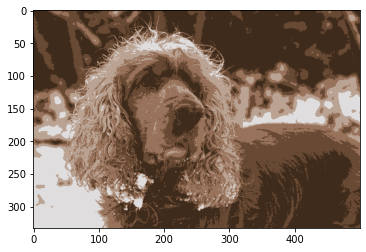

<Figure size 432x288 with 0 Axes>

In [60]:
J1 = cv2.imread(dir_imagenes+archivos[9])
J1=cv2.cvtColor(J1, cv2.COLOR_BGR2RGB)
twoDimage = J1.reshape((-1,3))
twoDimage = np.float32(twoDimage)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 5
attempts=15
ret,label,center=cv2.kmeans(twoDimage,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
result_image = res.reshape((J1.shape))
plt.figure()
plt.imshow(result_image)
plt.figure()


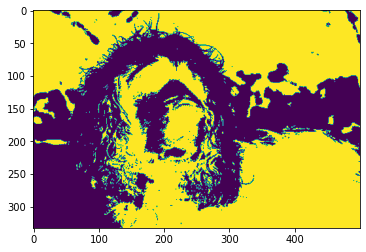

In [61]:
sample_image = cv2.imread(dir_imagenes+archivos[9])
img = cv2.cvtColor(sample_image,cv2.COLOR_BGR2RGB)

gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
_,thresh = cv2.threshold(gray, np.mean(gray), 255, cv2.THRESH_BINARY_INV)

plt.imshow(thresh)

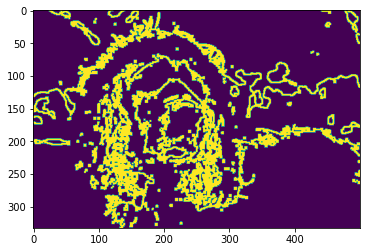

In [62]:
edges = cv2.dilate(cv2.Canny(thresh,0,255),None)

plt.imshow(edges)

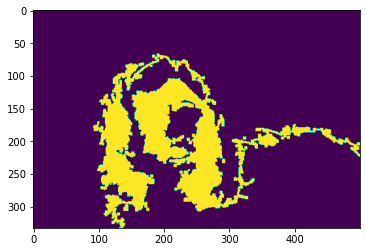

In [63]:
cnt = sorted(cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2], key=cv2.contourArea)[-1]
mask = np.zeros(np.shape(thresh), np.uint8)
masked = cv2.drawContours(mask, [cnt],-1, 255, -1)

plt.imshow(masked)

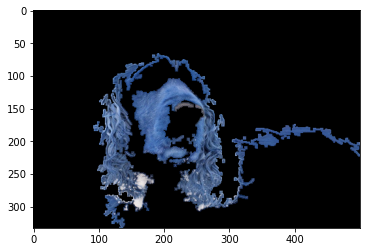

In [64]:
dst = cv2.bitwise_and(img, img, mask=mask)
segmented = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
plt.imshow(segmented)

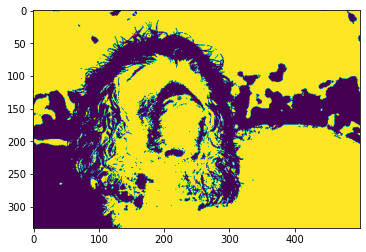

In [65]:
from skimage.filters import threshold_otsu
J1 = cv2.imread(dir_imagenes+archivos[9])        
J1=cv2.cvtColor(J1, cv2.COLOR_BGR2RGB)
img_gray=cv2.cvtColor(J1,cv2.COLOR_RGB2GRAY)

thresh = threshold_otsu(img_gray)
img_otsu  = img_gray < thresh

plt.imshow(img_otsu)

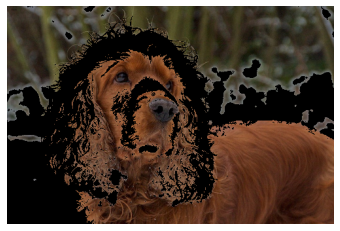

In [66]:
def filter_image(image, mask):

    r = image[:,:,0] * mask
    g = image[:,:,1] * mask
    b = image[:,:,2] * mask

    return np.dstack([r,g,b])

filtered = filter_image(J1, img_otsu)

plt.axis('off')
plt.imshow(filtered)



## Texturas

In [20]:
def mu_n(histograma, m, n):
    """Función que calcula el momento n.

    Args:
        histograma: histograma
        m (_type_): la media
        n (_type_): el momento a calcular
    """
    mu_n=0
    for i in range (256):
        mu_n=mu_n+((i-m)**n)*histograma[i]
    return mu_n

def calcular_descriptores_de_histograma(I):
    '''
    Calcula el histograma normalizado de la imagen I.
    Devuelve descriptores sobre el histograma calculado
    
    Parameters
    ----------
    I : imagen de 256 niveles de gris (uint8)

    Returns
    -------
    mean : double
    R : double
    skewness : double
    flatness : double
    uniformity : double
    entropy : double

    '''
    # calcular el histograma normalizado  
    numBins = 256
    histograma, bin_edges = np.histogram(I[:], np.arange(numBins+1), density=True)
    m=0
    entropy=0
    for i in range(numBins):
        m=m+i*histograma[i]
        if histograma[i]>0:
            entropy=entropy-(histograma[i]*np.log2(histograma[i]))
    mu2=mu_n(histograma, m,2)
    mu3=mu_n(histograma, m,3)
    mu4=mu_n(histograma, m,4)

    mean=m
    R=1-1/(1+mu2)
    skewness=mu3
    flatness=mu4
    uniformity = np.sum(histograma**2)
   
    return mean, R, skewness, flatness, uniformity, entropy

def calcular_descriptores_de_matriz_de_coocurrencia(I, distance, angle, levels=256, debug=False):
    '''
    Calcula la matriz de coocurrencia NORMALIZADA para la imagen I 
    para la combinación (distancia, angulo) deseado  
    Devuelve descriptores sobre la matriz de coocurrencia calculada
    Se implementa con funciones adecuadas de: 
        skimage.feature
       
    Parameters
    ----------
    I : imagen de 256 niveles de gris (uint8)
    distance : int, optional
        Distancia entre pixeles para calcular la coocurrencia.
    angle : double, optional
        Angulo (en radianes con respecto a la horizontal) para calcular la coocurrencia. 
    levels : int, optional . Por defecto 256.
        Usar solo para debuggear en imagenes artificiales pequeñas
    debug: bool, optional
        En caso de ser verdadero, imprime la matriz de coocurrencia 
    Returns
    -------
    contrast : double
    dissimilarity : double
    homogeneity : double
    energy : double
    correlation : double

    '''
    matriz_coocurrencia=greycomatrix(I, [distance], [angle],levels=levels)
    if debug:
        print("Matriz de coocurrencia: \n", matriz_coocurrencia[:, :, 0, 0])
    contrast = greycoprops(matriz_coocurrencia, 'contrast')[0][0]
    dissimilarity = greycoprops(matriz_coocurrencia, 'dissimilarity')[0][0]
    homogeneity = greycoprops(matriz_coocurrencia, 'homogeneity')[0][0]
    energy = greycoprops(matriz_coocurrencia, 'energy')[0][0]
    correlation = greycoprops(matriz_coocurrencia, 'correlation')[0][0]

    return contrast, dissimilarity, homogeneity, energy, correlation

def calcular_descriptores(I, angulo, distancia, datos, textura, animal):
    """Calcula los descriptores de histograma y de matriz de coocurrencia. Luego appendea a la lista datos.
    """
    mean, R, skewness, flatness, uniformity, entropy=calcular_descriptores_de_histograma(I)
    contrast, dissimilarity, homogeneity, energy, correlation=calcular_descriptores_de_matriz_de_coocurrencia(I, distancia, angulo, levels=256, debug=False)
    datos.append([textura,animal, mean, R, skewness, flatness, uniformity, entropy, contrast, dissimilarity, homogeneity, energy, correlation])
    return(datos)


def procesar_carpeta_texturas(direccion_img, direccion_lbl, distancia, angulo, plot=False):
    """ 
    Entra a la carpeta donde estan las imagenes de las texturas y procesa cada imagen. Devuelve los datos en una lista
    """

    datos=[["Raza", "Animal","Mean", "R", "Skewness", "Flatness", "Uniformity", "Entropy", "Contrast", "Dissimilarity", "Homogeneity", "Energy", "Correlation"]]
    animales = os.listdir(direccion_img)
    
    for animalito in animales:

        nombre_raza = animalito.rsplit('_', 1)[0]
        if nombre_raza[0].isupper():
            animal = 'Gato'
        else:
            animal = 'Perro'
        try:
            I = cv2.imread(direccion_img+animalito)
            I=I[:,:,0]
            nombre_archivo_mascara = os.path.splitext(animalito)[0] + '.png'
            ruta_mascara = os.path.join(direccion_lbl, nombre_archivo_mascara)
            mascara = cv2.imread(ruta_mascara, cv2.IMREAD_GRAYSCALE)
            #probar cual queda  mejor
            #mascara_binaria = cv2.compare(mascara, 1, cv2.CMP_EQ) | cv2.compare(mascara, 3, cv2.CMP_EQ)
            mascara_binaria = cv2.compare(mascara, 1, cv2.CMP_EQ) 
            imagen_sin_fondo = cv2.bitwise_and(I, I, mask=mascara_binaria)
            if plot:
                fig, axs = plt.subplots(1, 3, figsize=(10, 4))

                axs[0].imshow(cv2.cvtColor(I, cv2.COLOR_BGR2RGB))
                axs[0].axis('off')
                axs[0].set_title('Imagen original')

                axs[1].imshow(mascara, cmap='gray')
                axs[1].axis('off')
                axs[1].set_title('Máscara')

                axs[2].imshow(cv2.cvtColor(imagen_sin_fondo, cv2.COLOR_BGR2RGB))
                axs[2].axis('off')
                axs[2].set_title('Imagen sin fondo')

                plt.tight_layout()
                plt.show()
            
            datos=calcular_descriptores(imagen_sin_fondo, angulo, distancia, datos, nombre_raza, animal)
        except:
            print(animalito)
                    
    return(datos)




beagle


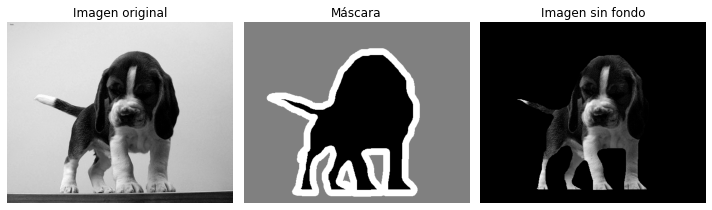

Abyssinian


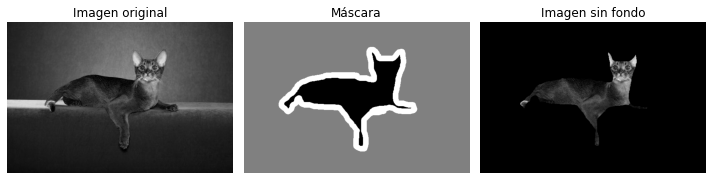

american_bulldog


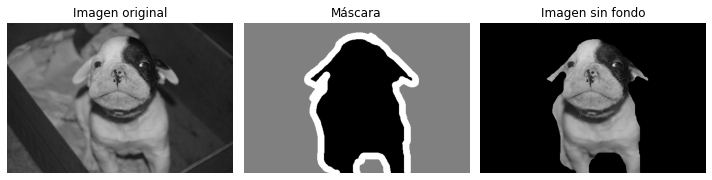

basset_hound


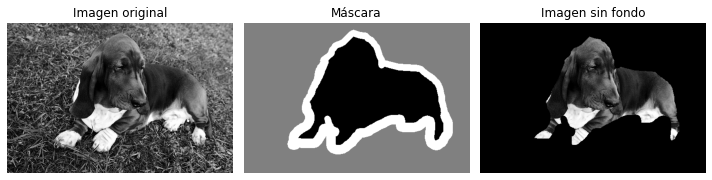

american_pit_bull_terrier


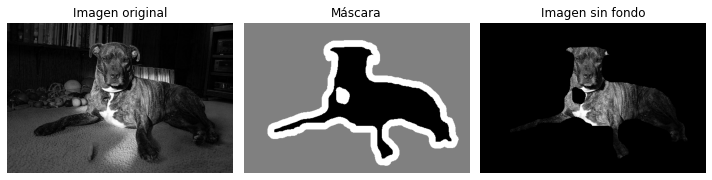

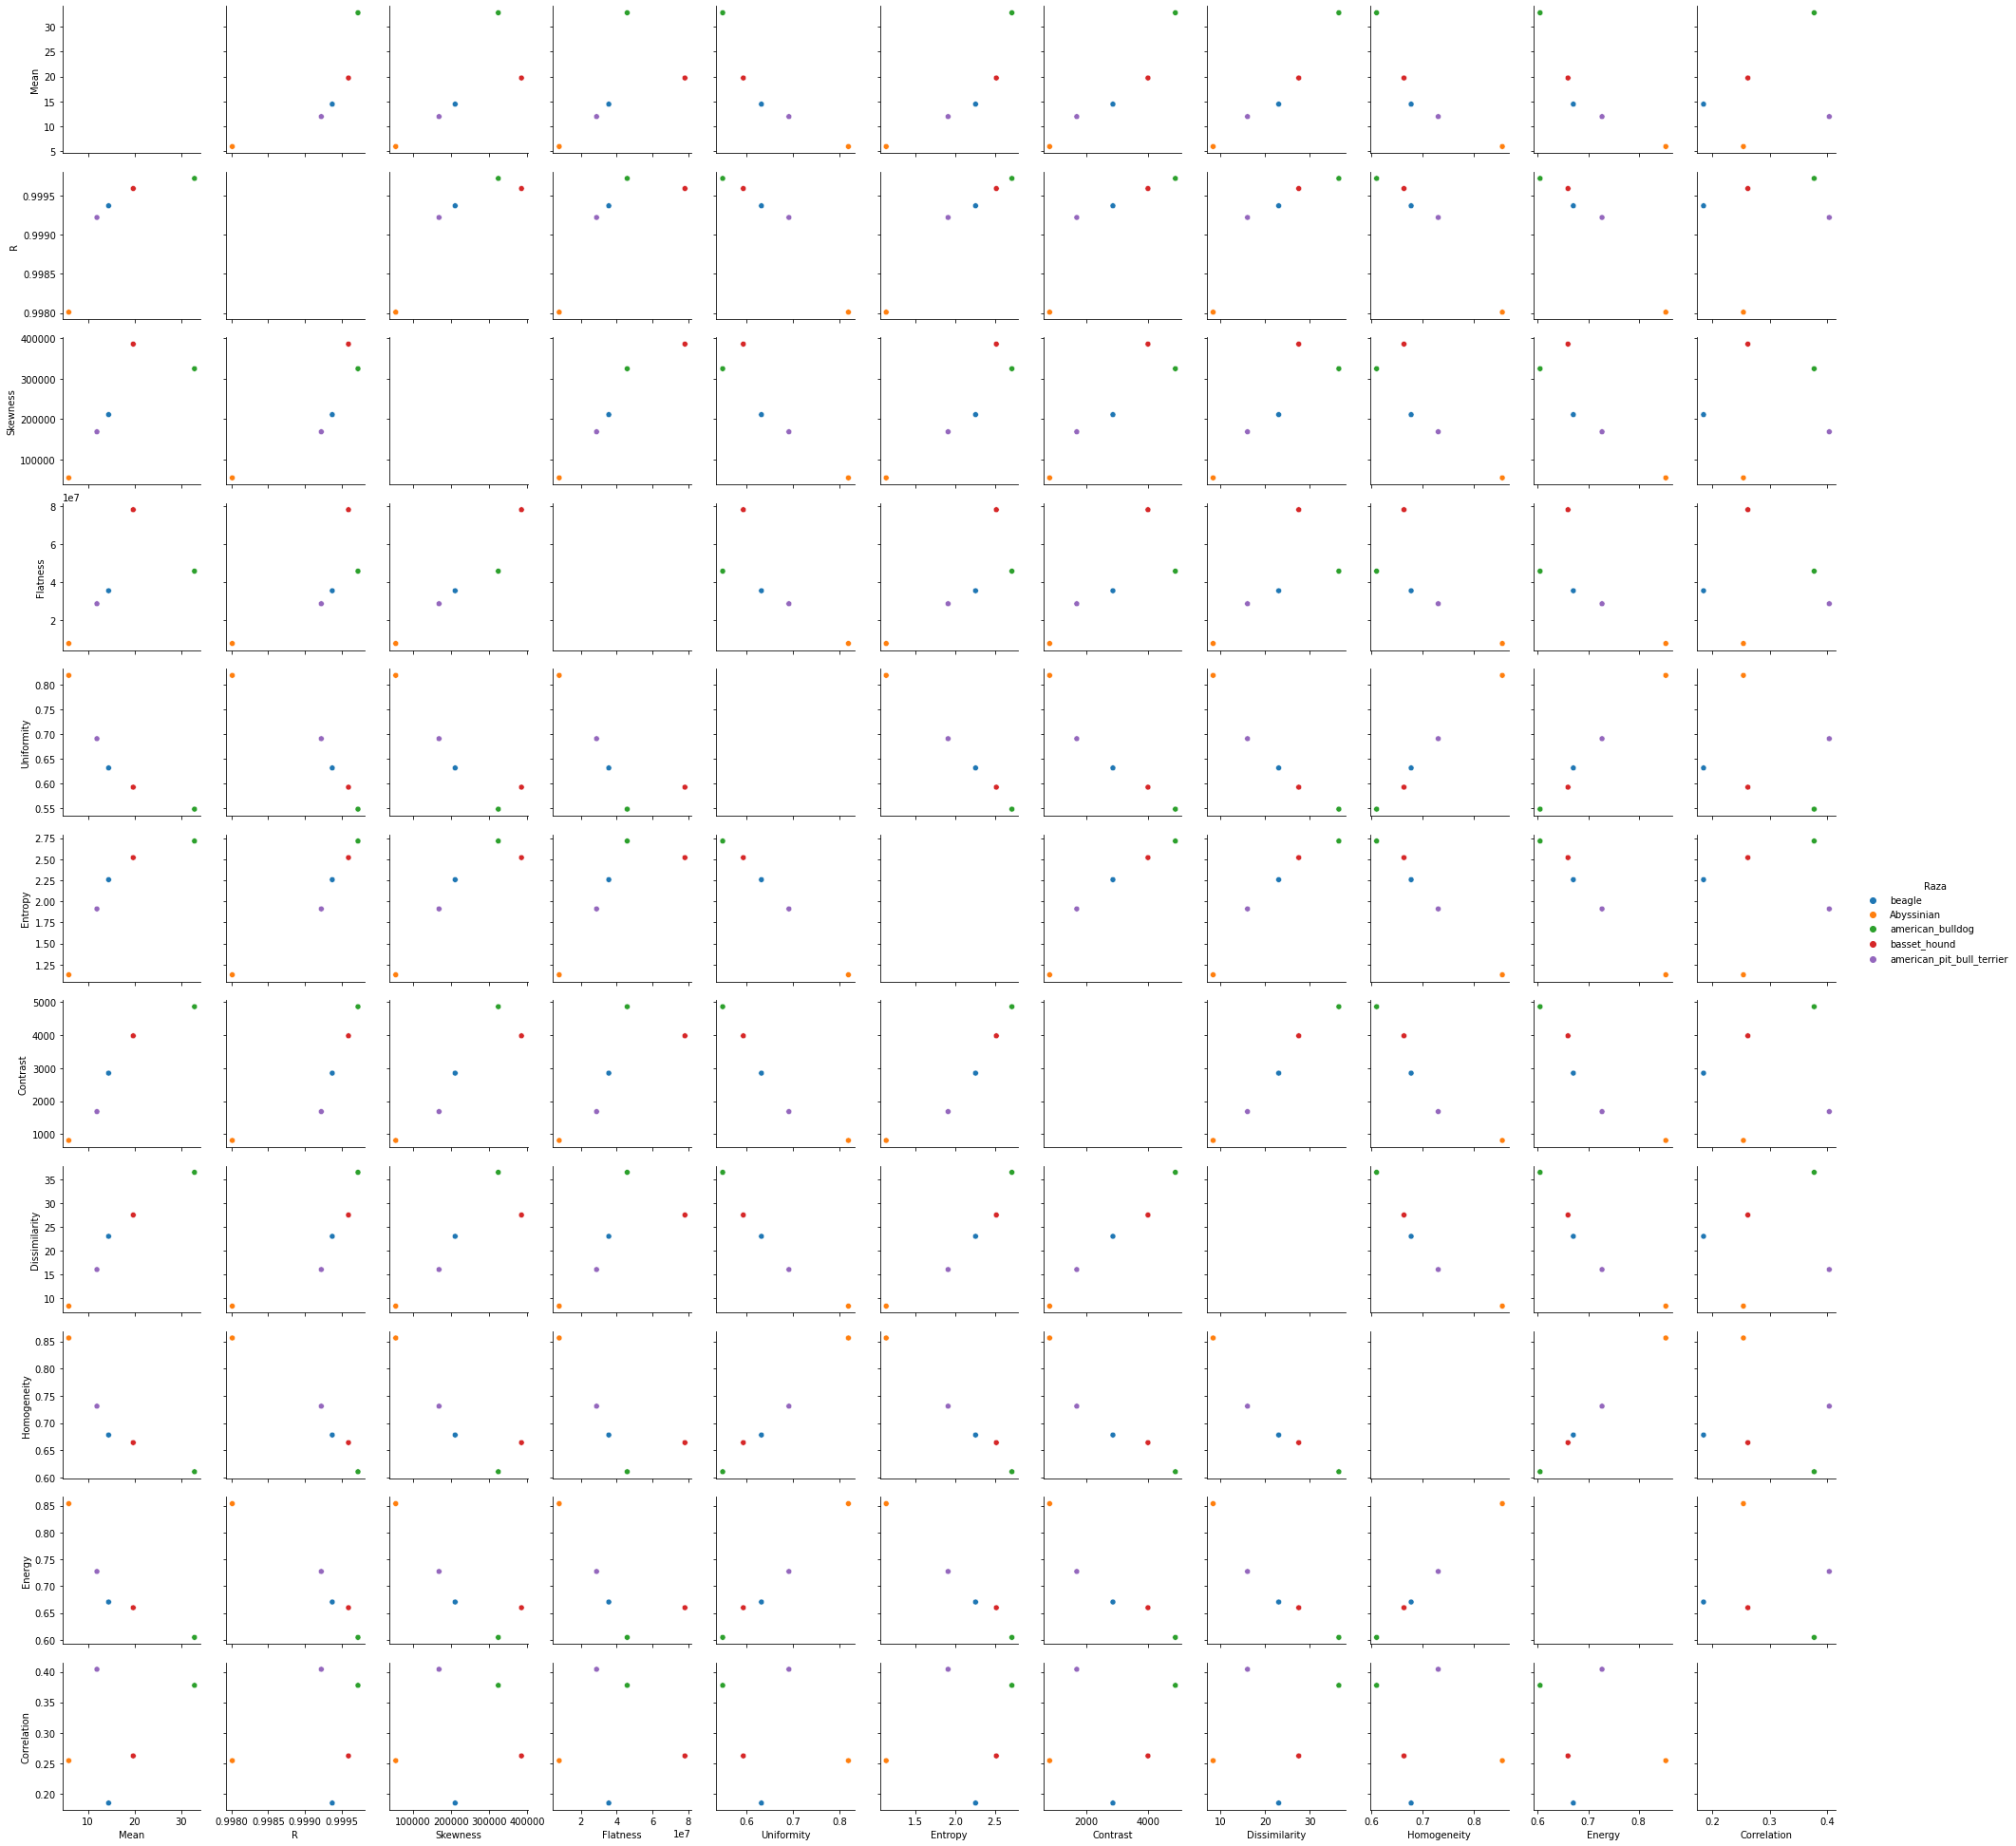

In [16]:
distancia=50
angulo=0
datos=procesar_carpeta_texturas(dir_imagenes_5,dir_labels_5, distancia, angulo, plot=True)
df = pd.DataFrame(datos[1:], columns=datos[0])

sn.pairplot(df, hue='Raza')

Abyssinian_34.jpg


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Egyptian_Mau_191.jpg
Abyssinian_100.mat


Corrupt JPEG data: premature end of data segment


Abyssinian_102.mat
Egyptian_Mau_177.jpg
Egyptian_Mau_167.jpg
Egyptian_Mau_139.jpg
Abyssinian_101.mat
Egyptian_Mau_145.jpg


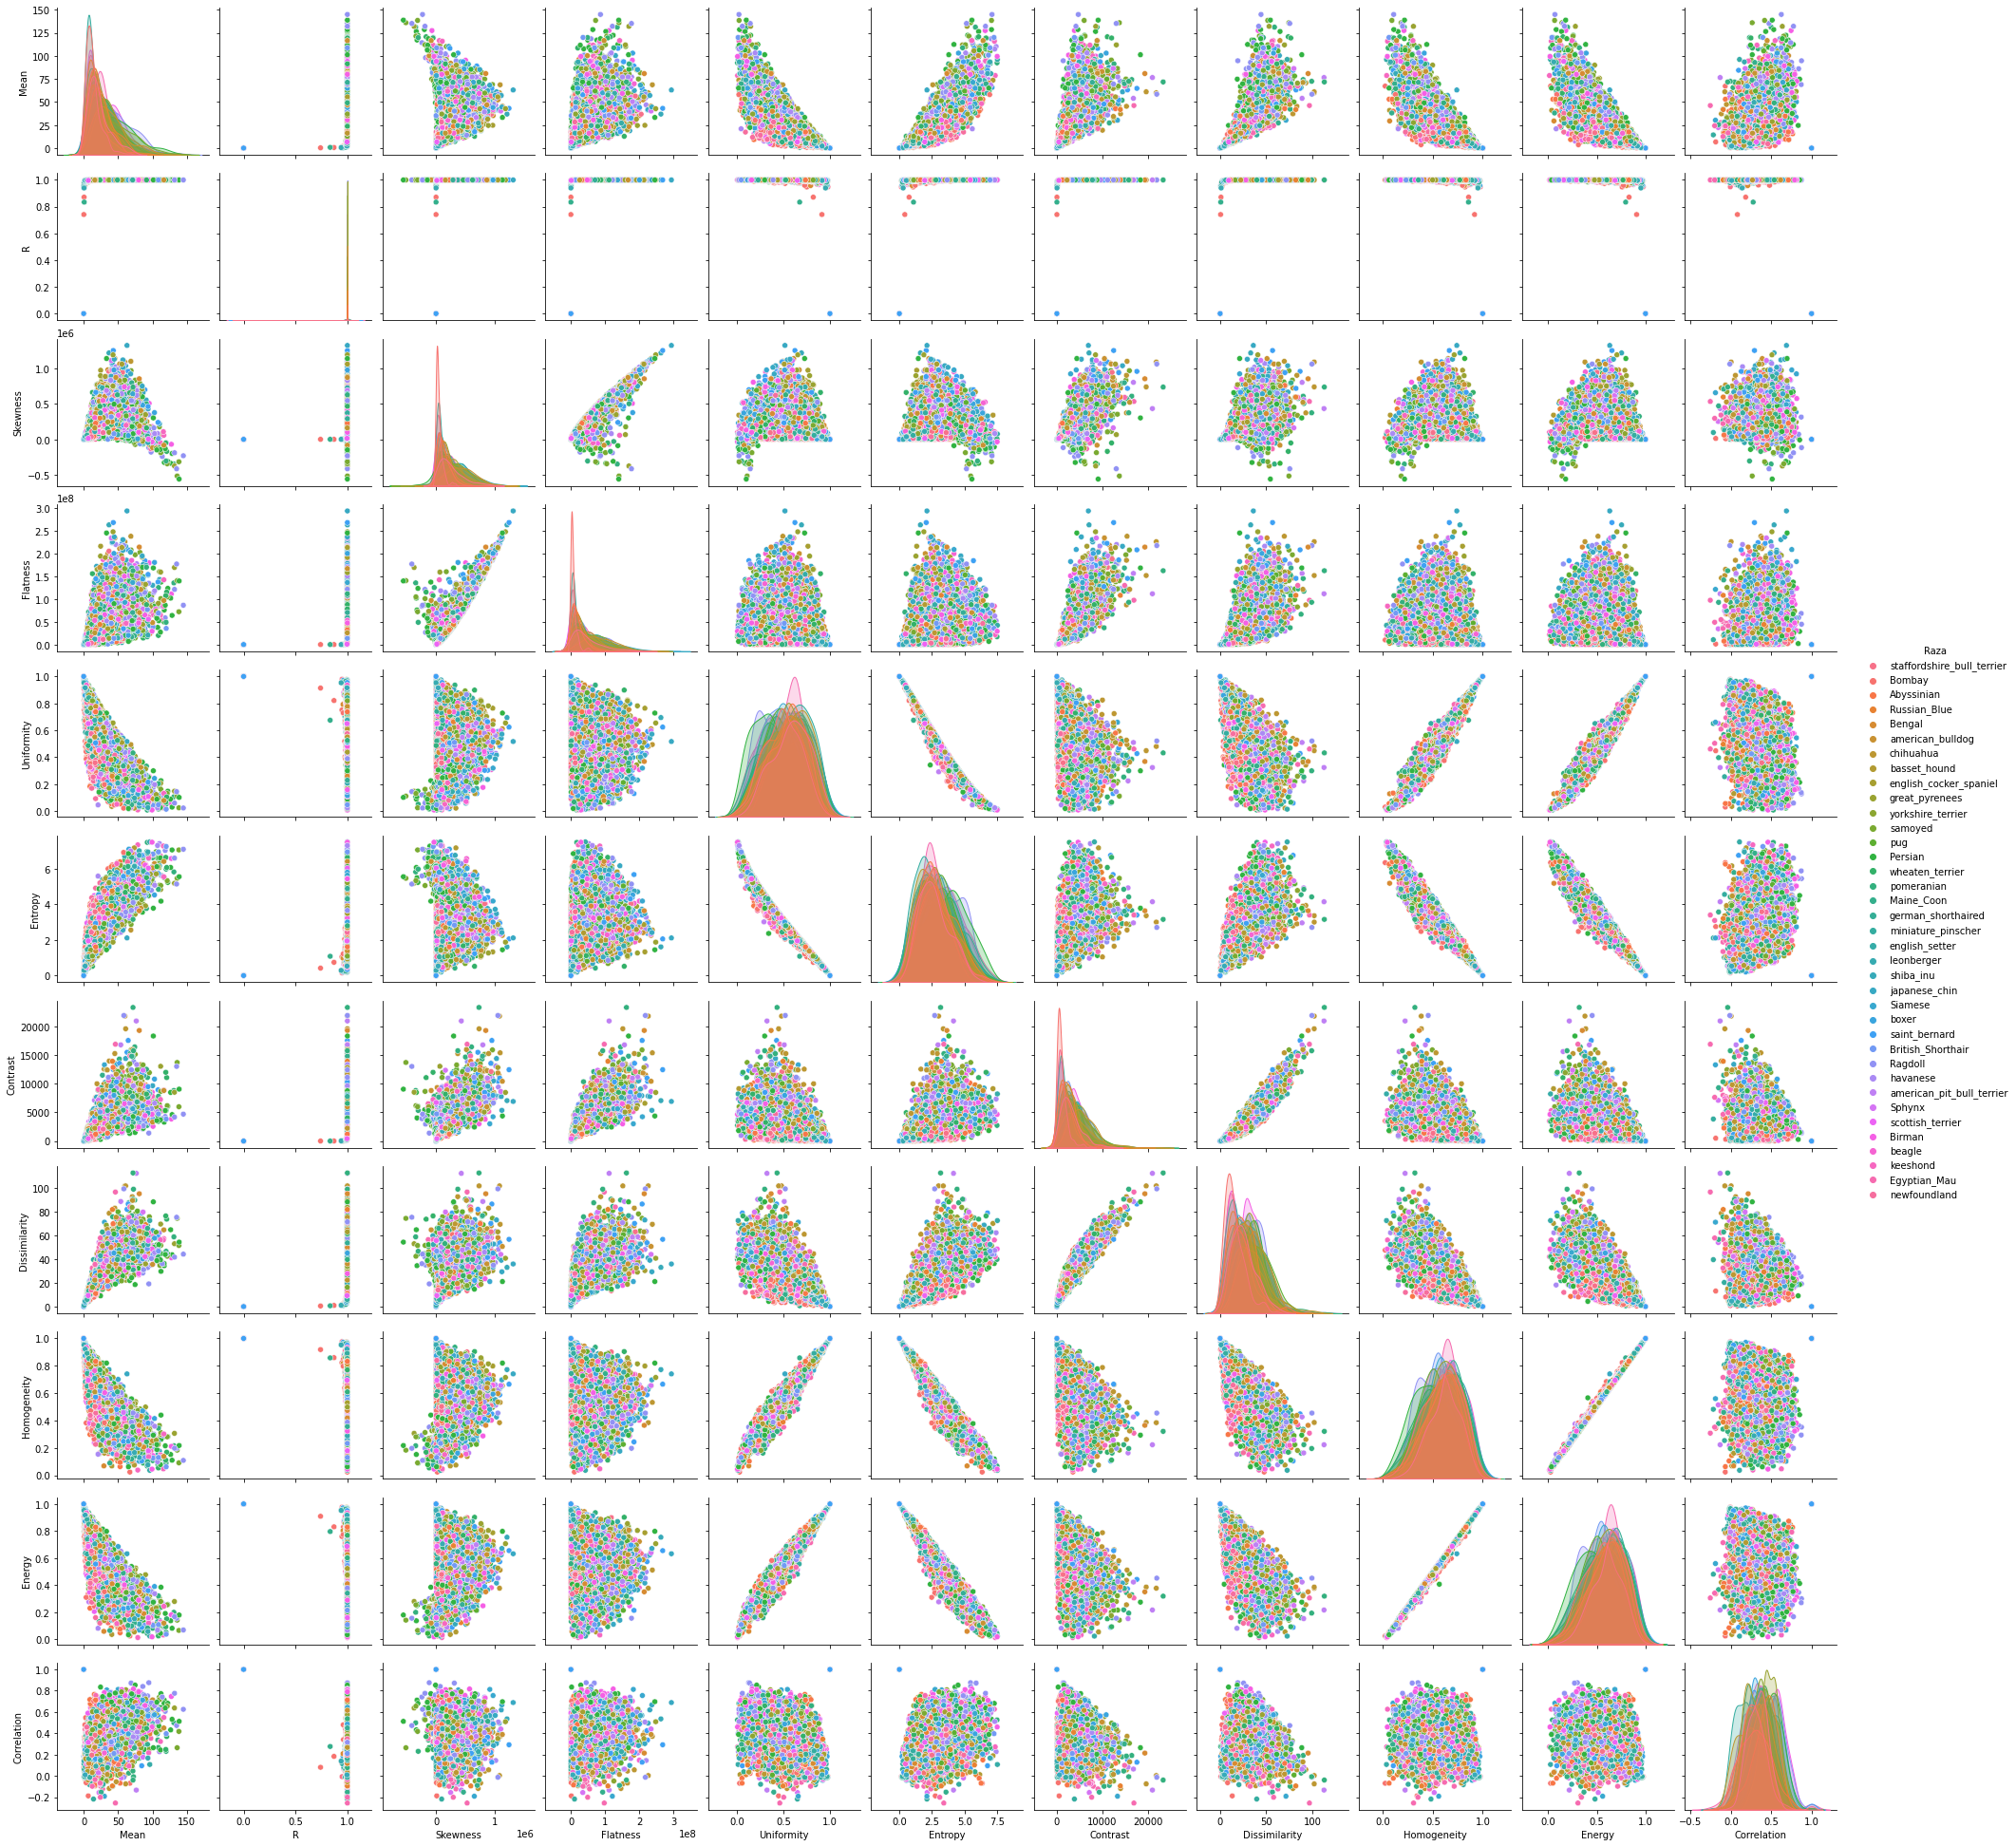

In [21]:
distancia=50
angulo=0
datos=procesar_carpeta_texturas(dir_imagenes,dir_labels, distancia, angulo, plot=False)
df = pd.DataFrame(datos[1:], columns=datos[0])

df.to_csv("datos.csv", index=False)
sn.pairplot(df, hue='Raza')

## Color

https://medium.com/lifeandtech/color-segmentation-using-gmm-7a8d900e48b

## Algoritmo

https://towardsdatascience.com/dog-breed-classification-using-deep-learning-concepts-23213d67936c

## Prediccion

Prediccion en chiste: pasarle una persona y ver que raza serías :)